# Speeding up the Kinetic Monte Carlo
Start with the Rabbits and Foxes KMC implementation from last notebook

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import random
random.seed(1) # so results don't change every time I execute

First, everything is as before, but we've split it into a few functions, one that runs a simulation, and one that analyzes many simulations.

In [2]:
def one_run():
    """
    This runs a single Kinetic Monte Carlo simulation
    """
    k1 = 0.015
    k2 = 0.00004
    k3 = 0.0004
    k4 = 0.04
    end_time = 600
    time = 0
    rabbit = 400  # this tracks the current number of rabbits
    fox = 200
    # We don't know how long these will be so start as lists and convert to arrays later
    times = []  # this keeps a list of the times at each time step
    rabbits = [] # this keeps a list of the number of rabbits at each time step
    foxes = []
    foxes_died = False
    rabbits_died = False

    while time < end_time:
        times.append(time)
        rabbits.append(rabbit)
        foxes.append(fox)
        rabbit_birth = k1 * rabbit
        rabbit_death = k2 * rabbit * fox
        fox_birth = k3 * rabbit * fox
        fox_death = k4 * fox

        sum_rates = rabbit_birth + rabbit_death + fox_birth + fox_death
        if sum_rates == 0:
            # print("everything dead at t=",time)
            rabbits_died = foxes_died = True
            times.append(end_time)
            rabbits.append(rabbit)
            foxes.append(fox)
            break
        wait_time = random.expovariate( sum_rates )
        time += wait_time
        choice = random.uniform(0, sum_rates)
        # Imagine we threw a dart at a number line with span (0, sum_rates) and it hit at "choice"
        # Foxes change more often than rabbits, so we'll be faster if we check them first!
        if choice < fox_birth:
            fox += 1 # fox born
            continue
        choice -= fox_birth
        if choice < fox_death:
            fox -= 1 # fox died
            if fox == 0:
                foxes_died = True
                break # For this assignment I don't care what happens to rabbits!
            continue
        choice -= fox_death
        if choice < rabbit_birth:
            rabbit += 1 # rabbit born
            continue
        rabbit -= 1 # rabbit died
        if rabbit == 0:
            rabbits_died = True
    
    times_array = np.array(times)
    rabbits_array = np.array(rabbits)
    foxes_array = np.array(foxes)
    
    return times_array, rabbits_array, foxes_array, foxes_died, rabbits_died


def full_analysis(runs=1000, function=one_run):
    """
    This does the full analysis, running `runs` KMC simulations,
    finding the second peak in each, recording cumulative statistics, etc.
    """
    
    dead_foxes = 0
    dead_rabbits = 0
    dead_everything = 0

    second_peak_times = []
    second_peak_foxes = []

    mean_times = np.zeros(runs)
    mean_foxes = np.zeros(runs)
    upper_quartile_times = np.zeros(runs)
    lower_quartile_times = np.zeros(runs)
    upper_quartile_foxes = np.zeros(runs)
    lower_quartile_foxes = np.zeros(runs)

    for run in range(runs):
        times, rabbits, foxes, foxes_died, rabbits_died = function()
        if foxes_died:
            dead_foxes += 1
        if rabbits_died:
            dead_rabbits += 1
            if foxes_died:
                dead_everything += 1

        index_of_second_peak = np.argmax(foxes*(times>200)*(foxes>100))
        if index_of_second_peak:
            second_peak_times.append(times[index_of_second_peak])
            second_peak_foxes.append(foxes[index_of_second_peak])

        if len(second_peak_times)>0:
            mean_times[run] = np.mean(second_peak_times)
            mean_foxes[run] = np.mean(second_peak_foxes)
            upper_quartile_times[run] = np.percentile(second_peak_times,75)
            lower_quartile_times[run] = np.percentile(second_peak_times,25)
            upper_quartile_foxes[run] = np.percentile(second_peak_foxes,75)
            lower_quartile_foxes[run] = np.percentile(second_peak_foxes,25)

        # We don't want to plot too many lines, but would be fun to see a few
        if run < 50:
            plt.plot(times, rabbits, 'b')
            plt.plot(times, foxes, 'g')
    plt.legend(['rabbits','foxes'],loc="best") # put the legend at the best location to avoid overlapping things
    plt.ylim(0,3000)
    plt.show()

    print("Rabbits died {} times out of {} or {:.1f}%".format(dead_rabbits, runs, 100*dead_rabbits/runs))
    print("Foxes died {} times out of {} or {:.1f}%".format(dead_foxes, runs, 100*dead_foxes/runs))
    print("Everything died {} times out of {} or {:.1f}%".format(dead_everything, runs, 100*dead_everything/runs))

    
    plt.semilogx(mean_times,'-r')
    plt.semilogx(upper_quartile_times,':r')
    plt.semilogx(lower_quartile_times,':r')
    plt.ylabel('Second peak time (days)')
    plt.xlim(10)
    plt.show()
    print("Second peak (days) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_times[-1], lower_quartile_times[-1], upper_quartile_times[-1]))

    plt.semilogx(mean_foxes,'-k')
    plt.semilogx(upper_quartile_foxes,':k')
    plt.semilogx(lower_quartile_foxes,':k')
    plt.ylabel('Second peak foxes')
    plt.xlim(10)
    plt.show()
    print("Second peak (foxes) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_foxes[-1], lower_quartile_foxes[-1], upper_quartile_foxes[-1]))

    from matplotlib.colors import LogNorm
    plt.hist2d(second_peak_times, second_peak_foxes, bins=40, norm=LogNorm())
    plt.xlim(0,600)
    plt.ylim(0)
    plt.colorbar()
    plt.axvline(200,linestyle=':')
    plt.axvline(mean_times[-1],color='r')
    plt.axhline(100,linestyle=':')
    plt.axhline(mean_foxes[-1],color='k')
    plt.show()

In Jupyter Notebooks (not normal Python scripts) you can start lines with a `%` to get some "magic" features. One is `timeit`. Starting with `%%timeit` will time the entire cell. Normally it automatically chooses some sensible number of repetitions, but we can force it to do only 1 like this:

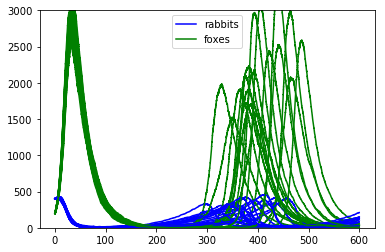

Rabbits died 22 times out of 1000 or 2.2%
Foxes died 695 times out of 1000 or 69.5%
Everything died 18 times out of 1000 or 1.8%


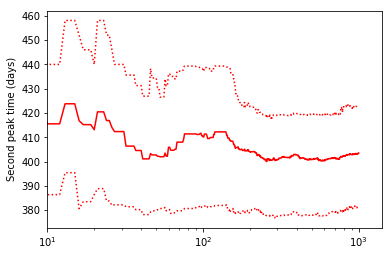

Second peak (days) is 403.6 with IQR [381.5-422.8] 


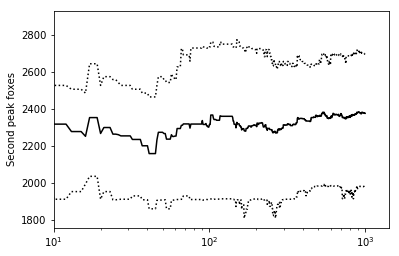

Second peak (foxes) is 2376.2 with IQR [1979.8-2696.5] 


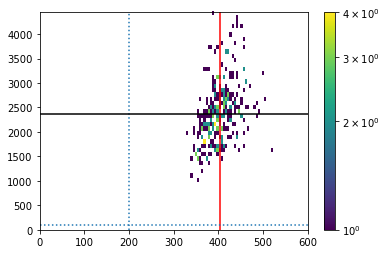

1 loop, best of 1: 43.5 s per loop


In [3]:
%%timeit -n1 -r1
full_analysis(runs=1000)

In [4]:
%timeit one_run()

10 loops, best of 3: 29.1 ms per loop


# Cython
In an anaconda prompt (the terminal on a mac), in your correct conda environment, type:

    conda install cython

In [5]:
# For jupyter notebook magic:
%load_ext Cython

First, just stick `%%cython` at the top of the cell in which we define functions, and see what difference it makes when we execute them.
If we add the `--annotate` flag it will show the C code that is generated, and we can begin to guess which bits are going to be slow (lots of yellow!)

In [6]:
%%cython --annotate
import random  # you have to import things within this cell so cython can find them
import numpy as np

def one_run_cython():
    """
    This runs a single Kinetic Monte Carlo simulation
    """
    k1 = 0.015
    k2 = 0.00004
    k3 = 0.0004
    k4 = 0.04
    end_time = 600
    time = 0
    rabbit = 400  # this tracks the current number of rabbits
    fox = 200
    # We don't know how long these will be so start as lists and convert to arrays later
    times = []  # this keeps a list of the times at each time step
    rabbits = [] # this keeps a list of the number of rabbits at each time step
    foxes = []
    foxes_died = False
    rabbits_died = False

    while time < end_time:
        times.append(time)
        rabbits.append(rabbit)
        foxes.append(fox)
        rabbit_birth = k1 * rabbit
        rabbit_death = k2 * rabbit * fox
        fox_birth = k3 * rabbit * fox
        fox_death = k4 * fox

        sum_rates = rabbit_birth + rabbit_death + fox_birth + fox_death
        if sum_rates == 0:
            # print("everything dead at t=",time)
            rabbits_died = foxes_died = True
            times.append(end_time)
            rabbits.append(rabbit)
            foxes.append(fox)
            break
        wait_time = random.expovariate( sum_rates )
        time += wait_time
        choice = random.uniform(0, sum_rates)
        # Imagine we threw a dart at a number line with span (0, sum_rates) and it hit at "choice"
        # Foxes change more often than rabbits, so we'll be faster if we check them first!
        if choice < fox_birth:
            fox += 1 # fox born
            continue
        choice -= fox_birth
        if choice < fox_death:
            fox -= 1 # fox died
            if fox == 0:
                foxes_died = True
                break # For this assignment I don't care what happens to rabbits!
            continue
        choice -= fox_death
        if choice < rabbit_birth:
            rabbit += 1 # rabbit born
            continue
        rabbit -= 1 # rabbit died
        if rabbit == 0:
            rabbits_died = True
    
    times_array = np.array(times)
    rabbits_array = np.array(rabbits)
    foxes_array = np.array(foxes)
    
    return times_array, rabbits_array, foxes_array, foxes_died, rabbits_died

In [7]:
%timeit one_run_cython()

10 loops, best of 3: 20.5 ms per loop


Not much improvement! But we haven't done much to help it yet.


## Random number generation
Just looking at random number generation, let's compare some alternatives

In [8]:
%timeit random.random()

The slowest run took 24.18 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 90.2 ns per loop


In [9]:
%%cython
# We'll use the built in C library's rand() function instead of Python's version
# Depending on your C library (operating system) it may not be as random,
# but is almost certainly faster.
from libc.stdlib cimport rand, RAND_MAX
import cython
@cython.cdivision(True)
cpdef double my_random():
    "My random number"
    return 1.0*rand()/RAND_MAX

In [10]:
%timeit my_random()

The slowest run took 43.93 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 43.9 ns per loop


For me the customized `my_random()` is almost twice as fast as `random.random()`

However, we can get almost all of that saving by just getting the `random.random()` function into the local namespace and avoiding the lookup caused by the `random.`!

In [11]:
local_random = random.random
%timeit local_random()

The slowest run took 98.55 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 51.7 ns per loop


# Optimized
Here's a somewhat optimized cythonized version of our KMC algorithm

In [12]:
%%cython --annotate
import random
import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log

import cython
@cython.cdivision(True)
cpdef tuple one_run_optimized():
    """
    This runs a single Kinetic Monte Carlo simulation
    """
    cdef double k1, k2, k3, k4, rabbit_birth, rabbit_death, fox_birth, fox_death
    cdef double end_time, time, sum_rates, 
    cdef double wait_time, choice
    cdef int rabbit, fox
    cdef list times, rabbits, foxes
    cdef bint foxes_died, everything_died
    cdef np.ndarray[np.float64_t, ndim=1] times_array, 
    cdef np.ndarray[np.int_t, ndim=1] rabbits_array, foxes_array

    k1 = 0.015
    k2 = 0.00004
    k3 = 0.0004
    k4 = 0.04
    end_time = 600
    time = 0
    rabbit = 400
    fox = 200
    # we don't know how long these will be so start as lists and convert to arrays later
    times = []
    rabbits = []
    foxes = []
    foxes_died = False
    rabbits_died = False

    while time < end_time:
        times.append(time)
        rabbits.append(rabbit)
        foxes.append(fox)
                    
        rabbit_birth = k1 * rabbit 
        rabbit_death = k2 * rabbit * fox
        fox_birth = k3 * rabbit * fox
        fox_death = k4 * fox
        sum_rates = rabbit_birth + rabbit_death + fox_birth + fox_death

        #wait_time = random.expovariate( sum_rates )
        wait_time = -log((RAND_MAX-rand())/1.0/RAND_MAX) / sum_rates 
        time += wait_time
        choice = sum_rates * rand() / RAND_MAX
        # Imagine we threw a dart at a number line with span (0, sum_rates) and it hit at "choice"
        # Foxes change more often than rabbits, so we'll be faster if we check them first!
        if choice < fox_birth:
            fox += 1 # fox born
            continue
        choice -= fox_birth
        if choice < fox_death:
            fox -= 1 # fox died
            if fox == 0:
                foxes_died = True
                break # For this assignment I don't care what happens to rabbits!
            continue
        choice -= fox_death
        if choice < rabbit_birth:
            rabbit += 1 # rabbit born
            continue
        rabbit -= 1 # rabbit died
        if rabbit == 0:
            rabbits_died = True
    
    times_array = np.array(times)
    rabbits_array = np.array(rabbits)
    foxes_array = np.array(foxes)
    
    return times_array, rabbits_array, foxes_array, foxes_died, rabbits_died

In [13]:
one_run_optimized()

(array([  0.00000000e+00,   8.04142722e-03,   1.19782009e-02, ...,
          5.95297093e+02,   5.95507657e+02,   5.97348132e+02]),
 array([400, 400, 400, ...,  24,  25,  25]),
 array([200, 199, 198, ...,   3,   3,   4]),
 False,
 False)

In [14]:
%timeit one_run_optimized()

100 loops, best of 3: 4.29 ms per loop


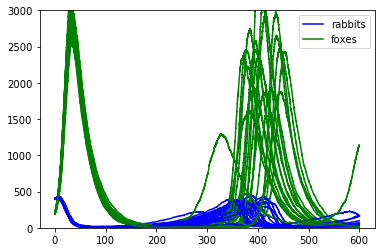

Rabbits died 18 times out of 1000 or 1.8%
Foxes died 726 times out of 1000 or 72.6%
Everything died 15 times out of 1000 or 1.5%


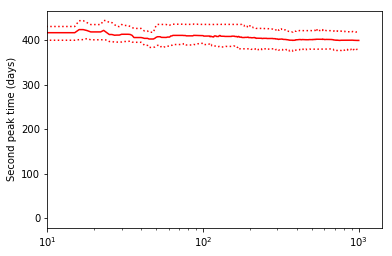

Second peak (days) is 399.4 with IQR [379.4-417.9] 


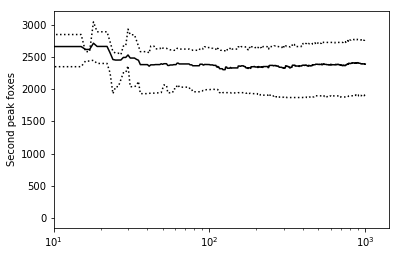

Second peak (foxes) is 2388.9 with IQR [1896.0-2759.0] 


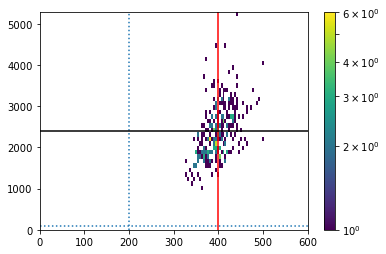

1 loop, best of 1: 8.84 s per loop


In [15]:
%%timeit -n1 -r1
full_analysis(runs=1000, function=one_run_optimized)

# Profiling the full_analysis function


You should never spend time optimizing (like I just did) before you profile. You may spend time optimizing the wrong thing. 

Python has built in profiling tools, but to do it in a notebook with a little magic we will use a new module called line_profiler:

    conda install line_profiler
    
However, the current one in anaconda is broken. Googling the error message will lead you to this pull request https://github.com/rkern/line_profiler/pull/65 in which someone has helpfully provided a patch. Until the fix makes it into the official version, you'll have to replace your line_profiler.py (probably somewhere like /Users/rwest/anaconda/envs/py3/lib/python3.5/site-packages/line_profiler.py) with this one
https://raw.githubusercontent.com/caethan/line_profiler/482772a8a43ac1f2bfcbf66ac5e015d0b146f5e6/line_profiler.py


In [16]:
%load_ext line_profiler

In [ ]:
def run_everything():
    # put your code here


In [ ]:
%lprun -f run_everything run_everything()

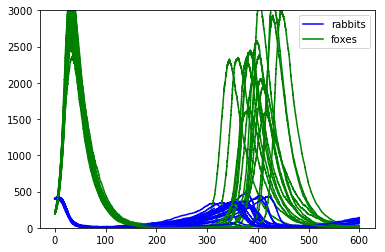

Rabbits died 260 times out of 10000 or 2.6%
Foxes died 6993 times out of 10000 or 69.9%
Everything died 206 times out of 10000 or 2.1%


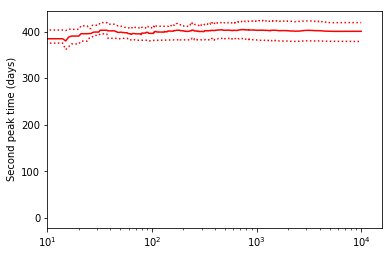

Second peak (days) is 400.4 with IQR [378.7-419.1] 


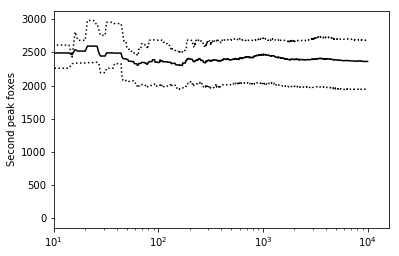

Second peak (foxes) is 2363.2 with IQR [1943.0-2680.0] 


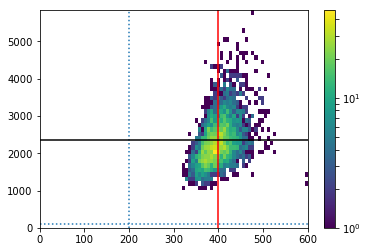

In [17]:
%lprun -f full_analysis full_analysis(runs=10000, function=one_run_optimized)

To profile within the cythonized code, see here: http://nbviewer.jupyter.org/gist/tillahoffmann/296501acea231cbdf5e7

# Faster analysis
A lot of time is spent collecting the cumulative convergenge plots. Once we know how many iterations we want to do to be confindent we've converged, all we need is the final number, and we can avoid that wasted time. Here is a faster analysis routine

In [18]:
def fast_analysis(runs=1000, function=one_run):
    """
    This does the lightweight analysis, running `runs` KMC simulations,
    finding the second peak in each, recording cumulative statistics, etc.
    
    It doesn't track convergence of the statistics.
    """
    
    dead_rabbits = 0
    dead_foxes = 0
    dead_everything = 0

    second_peak_times = []
    second_peak_foxes = []

    for run in range(runs):
        times, rabbits, foxes, foxes_died, rabbits_died = function()
        if foxes_died:
            dead_foxes += 1
        if rabbits_died:
            dead_rabbits += 1
            if foxes_died:
                dead_everything += 1

        index_of_second_peak = np.argmax(foxes*(times>200)*(foxes>100))
        if index_of_second_peak:
            second_peak_times.append(times[index_of_second_peak])
            second_peak_foxes.append(foxes[index_of_second_peak])
        
        # We don't want to plot too many lines, but would be fun to see a few
        if run < 5:
            plt.plot(times, rabbits, 'b')
            plt.plot(times, foxes, 'g')

    plt.legend(['rabbits','foxes'],loc="best") # put the legend at the best location to avoid overlapping things
    plt.ylim(0,3000)
    plt.show()

    if len(second_peak_times)>0:
        mean_times = np.mean(second_peak_times)
        mean_foxes = np.mean(second_peak_foxes)
        upper_quartile_times = np.percentile(second_peak_times,75)
        lower_quartile_times = np.percentile(second_peak_times,25)
        upper_quartile_foxes = np.percentile(second_peak_foxes,75)
        lower_quartile_foxes = np.percentile(second_peak_foxes,25)

    print("Rabbits died {} times out of {} or {:.1f}%".format(dead_rabbits, runs, 100*dead_rabbits/runs))
    print("Foxes died {} times out of {} or {:.1f}%".format(dead_foxes, runs, 100*dead_foxes/runs))
    print("Everything died {} times out of {} or {:.1f}%".format(dead_everything, runs, 100*dead_everything/runs))


    print("Second peak (days) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_times, lower_quartile_times, upper_quartile_times))
    print("Second peak (foxes) is {:.1f} with IQR [{:.1f}-{:.1f}] ".format(mean_foxes, lower_quartile_foxes, upper_quartile_foxes))

    from matplotlib.colors import LogNorm
    plt.hist2d(second_peak_times, second_peak_foxes, bins=40, norm=LogNorm())
    plt.xlim(0,600)
    plt.ylim(0)
    plt.colorbar()
    plt.axvline(200,linestyle=':')
    plt.axvline(mean_times,color='r')
    plt.axhline(100,linestyle=':')
    plt.axhline(mean_foxes,color='k')
    plt.show()

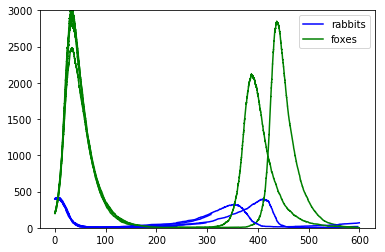

Rabbits died 29 times out of 1000 or 2.9%
Foxes died 695 times out of 1000 or 69.5%
Everything died 25 times out of 1000 or 2.5%
Second peak (days) is 398.7 with IQR [377.7-417.6] 
Second peak (foxes) is 2333.1 with IQR [1894.8-2694.2] 


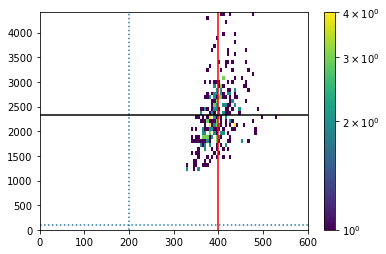

In [19]:
fast_analysis(runs=1000, function=one_run_optimized)

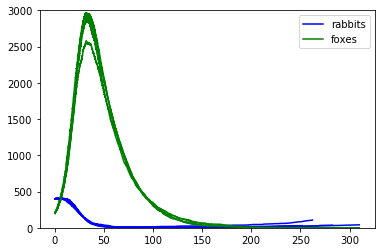

Rabbits died 250 times out of 10000 or 2.5%
Foxes died 6931 times out of 10000 or 69.3%
Everything died 208 times out of 10000 or 2.1%
Second peak (days) is 400.6 with IQR [380.0-418.5] 
Second peak (foxes) is 2360.7 with IQR [1939.0-2692.0] 


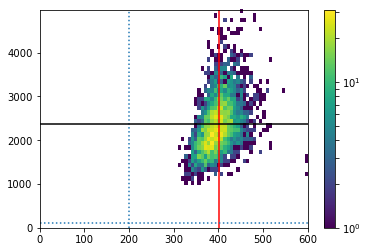

In [20]:
%lprun -f fast_analysis fast_analysis(runs=10000, function=one_run_optimized)

Now with the lightweight analysis, 94% of time is in the cythonized optimized inner loop. Probably can't make things much better here. Let's try 100k iterations.

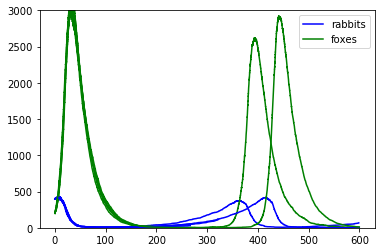

Rabbits died 2402 times out of 100000 or 2.4%
Foxes died 69840 times out of 100000 or 69.8%
Everything died 1954 times out of 100000 or 2.0%
Second peak (days) is 400.9 with IQR [379.2-419.6] 
Second peak (foxes) is 2368.1 with IQR [1946.0-2701.0] 


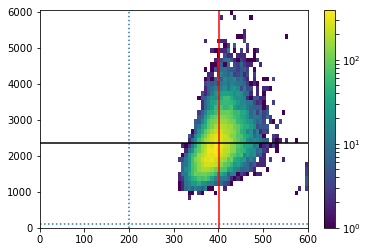

1 loop, best of 1: 7min 23s per loop


In [21]:
%%timeit -n1 -r1
fast_analysis(runs=100000, function=one_run_optimized)